# Libraries and GPU Verification

In [ ]:
!pip install imageio

In [ ]:
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import ast
import pandas as pd
import math
from multiprocessing import Pool
import os
import re
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models , losses
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time
import glob
import imageio
from IPython import display
import random
import folium

# Seleccionamos la versión más reciente de Tensorflow 2.

%matplotlib inline
plt.style.use("ggplot")
# Seleccionamos una semilla para los RNG (Random Number Generator)
tf.random.set_seed(123)
np.random.seed(123)


2024-09-26 18:06:23.966927: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-26 18:06:23.982685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 18:06:24.007057: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 18:06:24.007089: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 18:06:24.021914: I tensorflow/core/platform/cpu_feature_gua

In [4]:
print("Is using GPU: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is using GPU:  True


2024-09-26 18:06:26.380200: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-26 18:06:26.429834: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-26 18:06:26.434522: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

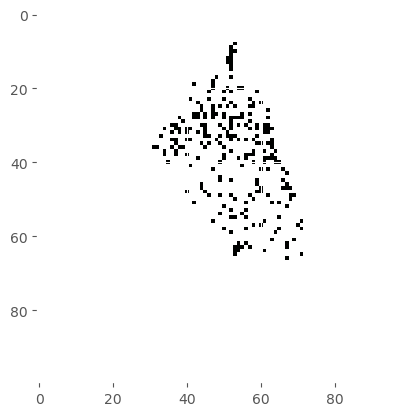

In [9]:
plt.imshow(array_modificado)
plt.show()

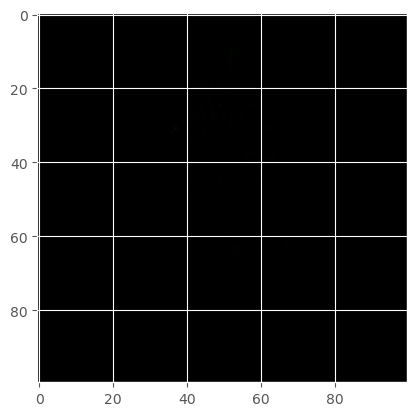

In [10]:
plt.imshow(images[0])
plt.show()

# Train

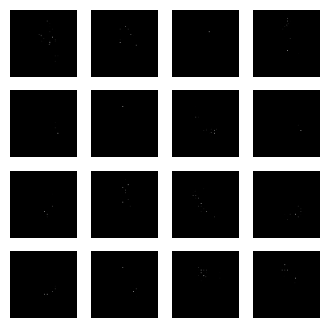

In [ ]:


# Cargar y preparar datos de entrenamiento (imágenes RGB de 100x100)
train_images = train_images.reshape(train_images.shape[0], 100, 100, 3).astype('float32')

# Definir tamaño de buffer y batch para entrenar en mini-lotes
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Crear dataset de entrenamiento con mezcla aleatoria y agrupación en lotes
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Función para crear el Generador
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((16, 16, 128)))
    
    # Capas convolucionales para aumentar la resolución progresivamente
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    
    return model

# Crear el generador
generator = make_generator_model()

# Generar una imagen inicial con ruido aleatorio
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# Función para crear el Discriminador
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    # Primera capa convolucional para extraer características
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[100, 100, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

# Crear el discriminador
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)  # Debería ser un número cercano a 0 o 1

# Función de pérdida basada en entropía cruzada binaria
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizadores para ambos modelos
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Configuración de checkpoints para guardar el progreso
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Definir hiperparámetros de entrenamiento
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print(f'Tiempo por época {epoch+1}: {time.time()-start:.2f} segundos')
    
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

# Función para generar y guardar imágenes
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')
    plt.savefig(f'image_epoch/image_at_epoch_{epoch:04d}.png')
    plt.show()

# Iniciar entrenamiento
train(train_dataset, EPOCHS)

# Restaurar último checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
